In [1]:
import os
os.chdir("../")

import semiolog as slg

In [2]:
semiotic = slg.Cenematic("en_bnc")

SLG [I]: Checking config correctness... Config correct!


100%|██████████| 3/3 [00:00<00:00, 134.79it/s]

SLG [I]: Dataset loaded from disk (TXT files)
SLG [I]: Vocabulary loaded from disk


  0%|          | 0/3 [00:00<?, ?it/s]

SLG [I]: nGrams loaded from disk (['2_5.json', '3_5.json', '4_5.json'])


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at models/en_bnc/paradigms/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


SLG [I]: Paradigmatizer loaded from disk


In [3]:
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import seaborn as sns
from os.path import isfile
import networkx as nx
import graphviz as gv
from ipywidgets import interact
import numpy as np

In [4]:
def extract_char_ngrams(text, n):
    n_grams = Counter(zip(*[text[i:] for i in range(n)]))
    return n_grams

In [34]:
ngrams_2 = {tuple(list(k)): v for k,v in semiotic.vocab.ng2_5.freq.items()}

In [36]:
terms = contexts = list(semiotic.vocab.alpha.keys())[:37]
terms_dict = {t:i for i,t in enumerate(terms)}

In [37]:
m_freq = slg.util.build_term_context_matrix(
    terms = terms,
    contexts = contexts,
    orthogonals = ngrams_2,
    normalizeQ = False)

Building oR Matrix...
Term-Context Matrix built in 0.01 secs.



In [38]:
m_pmi = slg.util.build_pmi_matrix(
    m_freq,
    type = "spmi",
    alpha = .5,
    normalizeQ = False,
    )

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.5
Done
PMI Matrix built in 0.04 secs.
Done



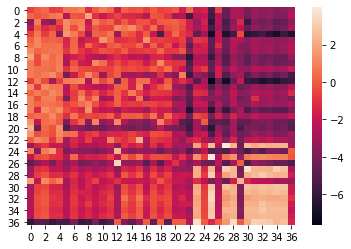

In [39]:
ax = sns.heatmap(m_pmi.toarray())

In [41]:
from numpy.linalg import svd, eig, inv

mf_type = "eig"

if mf_type == "svd":
    U, s, Vh = svd(m_pmi.toarray())

elif mf_type == "eig":
    s, U = eig(m_pmi.toarray())
    Vh = inv(U)


In [42]:
from random import randint
sent = semiotic.corpus.train[randint(0,100000)]["text"]
# sent = "This is very good"
norm_text = semiotic.syntagmatic.tokenizer.normalizer.normalize_str(sent)
sent

'Being summer , the window is wide open .'

In [43]:
sent_ngrams = extract_char_ngrams(norm_text,2)
pairs = sent_ngrams.keys()
# pairs = [(l,r) for l in terms for r in terms]

pair_scores = []
for pair in pairs:
    l = pair[0]
    r = pair[1]

    Tn_scores = []
    for type_n in range(s.size):
        Tl_score = U.T[type_n,terms_dict[l]]
        Tr_score = Vh[type_n,terms_dict[r]]
        Tn_score = Tl_score*Tr_score*s[type_n]
        signature = 1 if Tl_score>=0 else -1
        Tn_scores.append((Tn_score, type_n, signature))

    Tn_scores = sorted(Tn_scores,reverse=True)
    
    pair_scores.append((pair,Tn_scores[0]))

pair_scores_dict = dict(pair_scores)

segmentation_index = defaultdict(list)
for i, pair in enumerate(zip(norm_text, norm_text[1:])):
     segmentation_index[pair] += [i+1]

pair_scores_sorted = sorted(pair_scores,key=lambda x: x[1][0])

In [44]:
G = nx.DiGraph()

to_segment = [(norm_text,(0,len(norm_text)))]

while len(to_segment)>0:
    for segment, offset in to_segment:
        segmentation_index = defaultdict(list)
        pairs = []
        for i, pair in enumerate(zip(segment, segment[1:])):
            segmentation_index[pair] += [i+1]
            pairs.append(pair)
        best_pair = sorted([(pair_scores_dict[pair][0], pair) for pair in pairs])[0][1]
        best_cut = segmentation_index[best_pair][0]
        G.add_edge((segment,offset), (segment[:best_cut],(offset[0],offset[0]+best_cut)))
        G.add_edge((segment,offset), (segment[best_cut:],(offset[0]+best_cut,offset[1])))
        
        to_segment = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]
        to_segment = [seg for seg in to_segment if len(seg[0])>2]

In [45]:
seg_tree = G
seg_tree_graph = gv.Digraph(name="seg_tree")

tree_nodes_list = [(str(i), l) for l, i in list(seg_tree.nodes)]
for node in tree_nodes_list:
    seg_tree_graph.node(
        *node, color="white", fontsize="20", fontname="RobotoMono-Thin"
    )  # style="filled", color="grey")
seg_tree_graph.attr("edge", color="slategrey")
seg_tree_graph.edges([(str(p[1]), str(c[1])) for p, c in list(seg_tree.edges)])

@interact
def inter():
    return seg_tree_graph

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [46]:
T_score, Tn, T_sign = pair_scores[10][1]

Tn = 10
T_sign = -1
print(Tn)
print(T_score)

type_L = sorted([(round(score*T_sign,2),term) for term, score in zip(terms,U.T[Tn])], reverse=True)
type_R = sorted([(round(score*T_sign,2),context) for context, score in zip(contexts,Vh[Tn])], reverse=True)
slg.util.df([type_L[:15],type_R[:15]])

10
(0.40816471271105154-0.05328055479687205j)


<ipython-input-46-ea18d0b6c492>:8: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  type_L = sorted([(round(score*T_sign,2),term) for term, score in zip(terms,U.T[Tn])], reverse=True)
<ipython-input-46-ea18d0b6c492>:9: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  type_R = sorted([(round(score*T_sign,2),context) for context, score in zip(contexts,Vh[Tn])], reverse=True)


,0,1
0,"((0.36+0.08j), a)","((1+0.7j), u)"
1,"((0.2-0.01j), x)","((0.55-0.81j), o)"
2,"((0.19-0.13j), y)","((0.39+0.12j), v)"
3,"((0.18-0.04j), d)","((0.36+0.69j), w)"
4,"((0.15-0.05j), s)","((0.33+0.23j), d)"
5,"((0.14-0.03j), t)","((0.31-0.17j), 1)"
6,"((0.13+0.03j), £)","((0.22-0.27j), q)"
7,"((0.11+0.1j), n)","((0.21-0.13j), 3)"
8,"((0.11-0.06j), u)","((0.17+0.4j), f)"
9,"((0.09+0.1j), o)","((0.16-0.21j), 5)"


In [47]:
tl_vector = m_pmi.T[terms_dict["4"]].toarray()

In [48]:
U_projection = tl_vector.dot(U)
U_projection

array([[ 14.23609017+0.j        , -17.76429664+0.j        ,
         -2.03120046+0.j        ,   4.72969412+0.97850303j,
          4.72969412-0.97850303j,  -0.02126664+1.15454518j,
         -0.02126664-1.15454518j,  -0.65657083+2.28277402j,
         -0.65657083-2.28277402j,  -3.08283737+1.44334338j,
         -3.08283737-1.44334338j,  -0.09851013-2.23513747j,
         -0.09851013+2.23513747j,  -1.0468009 +0.j        ,
          3.65042439+1.07410596j,   3.65042439-1.07410596j,
          2.01598924-2.83975379j,   2.01598924+2.83975379j,
          2.47388744+1.63888998j,   2.47388744-1.63888998j,
          1.17623174+0.j        ,   1.00572359+1.35848692j,
          1.00572359-1.35848692j,  -1.39846556+0.j        ,
          0.80123555+0.76207912j,   0.80123555-0.76207912j,
         -1.52448237+0.87631243j,  -1.52448237-0.87631243j,
         -0.71395116+1.13989912j,  -0.71395116-1.13989912j,
         -2.37555084+0.j        ,  -1.61178298-0.12134959j,
         -1.61178298+0.12134959j,   0.83

In [49]:
np.argsort(U_projection)

array([[ 1, 10,  9, 30,  2, 31, 32, 27, 26, 23, 13, 29, 28,  8,  7, 36,
        11, 12,  6,  5, 35, 34, 25, 24, 33, 22, 21, 20, 16, 17, 19, 18,
        15, 14,  4,  3,  0]])